In [1]:
import cvxpy as cp
import math
import matplotlib.pyplot as plt 
from sklearn.datasets import load_digits
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pylab
import sys
import pandas as pd
from sklearn.naive_bayes import BernoulliNB
import pickle

In [2]:
sys.path.append("../code/")
import utils
from LR2NB import LR2NB

In [3]:
sys.setrecursionlimit(20000)
%load_ext autoreload
%autoreload 2

# Loading MNIST 3v5

In [4]:
folder = "../data/binaryizedMNIST-3-5/"
X_train = pd.read_csv(folder + "train-3-5-images.txt").values
y_train = pd.read_csv(folder + "train-3-5-labels.txt").values.ravel()
X_test = pd.read_csv(folder + "test-3-5-images.txt").values
y_test = pd.read_csv(folder + "test-3-5-labels.txt").values.ravel()

<Figure size 432x288 with 0 Axes>

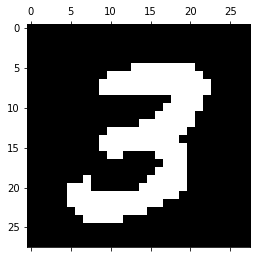

In [5]:
plt.gray()
plt.matshow(X_train[0].reshape( (28,28) )) 


### Load Pretrained LR and NaCL

In [6]:
clf = utils.load("../pretrained/lr_10.pickle2")
W = np.hstack((clf.intercept_[:,None], clf.coef_))[0]
nacl = utils.load('../pretrained/lr2nb_10.pickle2')
print("Relaxed sums are tight (EPS = {}): {}".format(1e-6, nacl.__validate_relaxed_sums__(1e-6)))
print("NaCL Accuray: {}".format( np.average(nacl.classify(X_test) == y_test)) )

Relaxed sums are tight (EPS = 1e-06): True
NaCL Accuray: 0.965281430826


# Sufficient Explanations

In [7]:
def give_values(lr2nb, idx = 0):

    Values = []
    EPS = 1e-10
    Pval = np.log( lr2nb.p.value / lr2nb.p_.value + EPS)
    for i in range(X_test.shape[1]):
        val = 0.0
        if X_test[idx][i] == 1:
            val += np.log(lr2nb.A[i].value + EPS)
            val -= np.log(lr2nb.B[i].value + EPS)
        else:
            val += np.log(lr2nb.A_[i].value + EPS)
            val -= np.log(lr2nb.B_[i].value + EPS)

        Values.append( (val, i) )
    
    return Pval, Values

def give_AB(Pval, Values, EPS = 1e-8):
    cur = np.sum([Values[i][0] for i in range(len(Values)) ]) + Pval
    
    A = []
    B = []
    Z = [] # Used for features below EPS threshold, treated as zero

    for i in range(len(Values)):
        if np.abs(Values[i][0]) < EPS:
            Z.append(Values[i])
        elif (cur < 0 and Values[i][0] < 0) or (cur > 0 and Values[i][0] > 0):
            A.append(Values[i])
        else:
            B.append(Values[i])


    B = sorted(B, key = lambda x: np.abs(x[0]))
    A = sorted(A, key = lambda x: np.abs(x[0]))
    
    return A,B, Z

def give_explanations(A, B, Z, Pval, Values, idx=0):
    curPval = np.sum([Values[i][0] for i in range(len(Values)) ]) + Pval
    X_copy = np.array(X_test[idx])
    X_copy_2 = np.array(X_test[idx])
    mask = np.zeros(X_copy.shape)
    mask2 = np.zeros(X_copy.shape)

    for i in range(len(Z)):
        X_copy[Z[i][1]] = -1
        X_copy_2[Z[i][1]] = -1
        mask[Z[i][1]] = 1
        mask2[Z[i][1]] = 1
    
    for i in range(len(A)):
        if np.sign(curPval - A[i][0]) == np.sign(curPval):    
            curPval -= A[i][0]
            X_copy[A[i][1]] = -1
            X_copy_2[A[i][1]] = -1
            mask[A[i][1]] = 1
            mask2[A[i][1]] = 1
        else:
            X_copy_2[A[i][1]] = -1
            mask2[A[i][1]] = 1
            break
            
    return X_copy, mask, X_copy_2, mask2

def plot_exp(X_copy, mask1, X_copy_2, mask2, A, B, Z, W, curPval, lr2nb, save_name = 'explanation',idx = 0 ):
    plt.gray()
    plt.figure(figsize=(4,1))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)

    plt.tight_layout()
    
    ax1.set_axis_off()
    ax2.set_axis_off()
    ax3.set_axis_off()
    ax4.set_axis_off()
    
    X_pos = np.array(X_test[idx])
    mask_p = np.zeros(X_pos.shape)
    for i in range(len(A)):
        if X_pos[A[i][1]] == 0:
            X_pos[A[i][1]] = -1 # to make it stay black
    for i in range(len(B)):
        X_pos[B[i][1]] = 0 # to make it gray
        mask_p[B[i][1]] = 1
    for i in range(len(Z)):
        X_pos[Z[i][1]] = 0 # to make it gray
        mask_p[Z[i][1]] = 1
              
    explaination = np.array(mask1)
    for i in range(len(B)):
        explaination[B[i][1]] = 1
    
    X_ours = np.array(X_test[idx])
    for i in range(len(explaination)):
        if explaination[i] == 0: 
            if X_ours[i] == 0:
                X_ours[i] = -1
        # if we removed it
        else:
            X_ours[i] = 0
        
    feature_to_choose = np.sum(X_ours != 0)
    
    W2 = [ (W[i] * (-1 if X_test[idx][i-1] == 0 else 1), i-1) for i in range(1,len(W)) ]
    W2 = sorted(W2, key = lambda x: x[0], reverse = (curPval > 0) )

    X_w = np.copy(X_test[idx])
    mask_w = np.zeros(X_w.shape)
    for i in range(min(feature_to_choose, len(W2))):
        if X_w[W2[i][1]] == 0:
            X_w[W2[i][1]] = -1 # to make it stay black  
    for i in range(feature_to_choose, len(W2)):
        X_w[W2[i][1]] = 0
        mask_w[W2[i][1]] = 1
    
    ax1.imshow(X_test[idx].reshape( (28,28) )) 
    ax2.imshow(X_pos.reshape( (28,28) )) 
    ax3.imshow(X_w.reshape((28,28)))    
    ax4.imshow(X_ours.reshape( (28,28) )) 
    
    no_missing = np.zeros(X_test[idx].shape)
    odds = lr2nb.odd([X_test[idx], X_test[idx], X_test[idx], X_test[idx]], missing = [mask_p, explaination, no_missing, mask_w])
    
    plt.savefig('{}.pdf'.format(save_name), bbox_inches='tight')
    return plt

def sigmoid(x):  
    return 1/ (1 + np.exp(-x) )
    
def do_it(a, idx = 0, save = "explanation", EPS = 1e-8):
    Pval, Values = give_values(a, idx = idx)    
    curPval = np.sum([Values[i][0] for i in range(len(Values)) ]) + Pval
    A, B, Z = give_AB(Pval, Values, EPS = EPS)
    X1, mask1, X2, mask2 = give_explanations(A,B, Z, Pval, Values, idx = idx)
    plot_exp(X1, mask1, X2, mask2, A, B, Z, W, curPval, a, save_name = save, idx = idx)

In [8]:
# Finding miss classified examples
missClass = clf.predict(X_test) != y_test
missIdx = []
for i in range(missClass.shape[0]):
    if missClass[i]:
        missIdx.append(i)

### Few examples

<Figure size 432x288 with 0 Axes>

<Figure size 288x72 with 0 Axes>

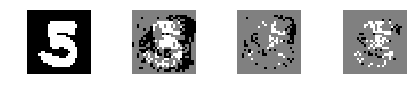

In [9]:
idx = missIdx[7]
do_it(nacl, idx, save="explanation_miss_3", EPS=1e-7)

<Figure size 432x288 with 0 Axes>

<Figure size 288x72 with 0 Axes>

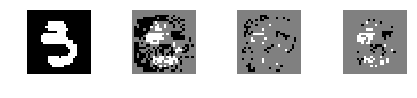

In [10]:
idx = missIdx[20]
do_it(nacl, idx, save="explanation_miss_3", EPS=1e-7)

In [11]:
missIdx = sorted(missIdx, key= lambda x: nacl.odd(X_test[x:x+1], prob=True)[0])

<Figure size 432x288 with 0 Axes>

<Figure size 288x72 with 0 Axes>

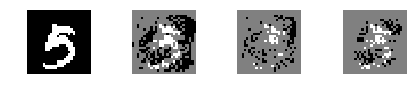

In [12]:
idx = missIdx[-17]
do_it(nacl, idx, save="explanation_miss_5", EPS=1e-7)

<Figure size 432x288 with 0 Axes>

<Figure size 288x72 with 0 Axes>

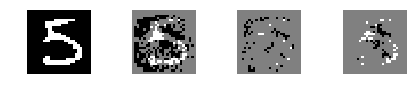

In [13]:
do_it(nacl, 0, save="explanation_5", EPS=1e-7)

<Figure size 432x288 with 0 Axes>

<Figure size 288x72 with 0 Axes>

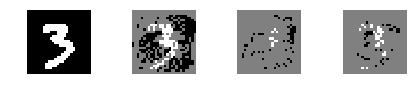

In [14]:
do_it(nacl, 3, save="explanation_3", EPS=1e-7)